In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os
%matplotlib inline
#plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,FunctionTransformer,StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit, train_test_split, learning_curve,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
rnd_state = 0

In [3]:
# create a database connection
sqluser = 'maxim'
dbname = 'maxim'
schema_name = 'mimiciii'
queries_dir = './queries/'

In [4]:
# Connect to local postgres version of mimic
connect = psycopg2.connect(dbname=dbname, user=sqluser)
cursor = connect.cursor()
#cur.execute('SET search_path to {}'.format(schema_name))

In [4]:
# Load in the query from file
query='DROP TABLE IF EXISTS mimiciii.vitalsfirstday;'
cursor.execute(query)
f = os.path.join(queries_dir,'vitals-first-day.sql')
with open(f) as fp:
    query = ''.join(fp.readlines())
    
# Execute the query
print('Generating table \'vitalsfirstday\' using {} ...'.format(f),end=' ')
cursor.execute(query)
print('done.')
connect.commit()

Generating table 'vitalsfirstday' using ./queries/vitals-first-day.sql ... done.


In [4]:
query = """
SELECT *
FROM mimiciii.admissions;
"""
cursor.execute(query)
# Load the result of the query into a dataframe
ad = pd.read_sql_query(query, connect)

In [5]:
ad.shape

(58976, 19)

In [6]:
ad.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,None,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaT,NaT,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,NaT,NaT,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [7]:
query = """
SELECT *
FROM mimiciii.vitalsfirstday;
"""
cursor.execute(query)
# Load the result of the query into a dataframe
vf = pd.read_sql_query(query, connect)

In [8]:
vf.shape

(59247, 27)

In [9]:
vf.head()

,subject_id,hadm_id,icustay_id,heartrate_min,heartrate_max,heartrate_mean,sysbp_min,sysbp_max,sysbp_mean,diasbp_min,diasbp_max,diasbp_mean,meanbp_min,meanbp_max,meanbp_mean,resprate_min,resprate_max,resprate_mean,tempc_min,tempc_max,tempc_mean,spo2_min,spo2_max,spo2_mean,glucose_min,glucose_max,glucose_mean
0,2,163353,243653,140.0,140.0,140.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,145834,211552,75.0,168.0,111.785714,64.0,217.0,102.960000,28.0,74.0,55.720000,40.000000,259.000,75.692812,5.0,24.0,17.361111,36.200001,37.599998,37.002881,74.0,100.0,97.870968,136.0,306.0,232.416667
2,4,185777,294638,74.0,111.0,89.217391,97.0,139.0,118.000000,55.0,81.0,69.000000,69.000000,100.333,85.333321,18.0,32.0,25.352941,36.333334,37.444445,36.844445,91.0,100.0,97.500000,153.0,266.0,199.666667
3,6,107064,228232,76.0,100.0,84.160000,127.0,187.0,153.647059,40.0,72.0,56.558824,72.666702,100.000,84.539218,8.0,20.0,12.320000,36.000002,37.333332,36.515152,84.0,100.0,99.200000,102.0,181.0,148.500000
4,7,118037,236754,115.0,121.0,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
query = """
SELECT
vf.subject_id,
vf.hadm_id,
vf.icustay_id,
ad.admission_type,
ad.discharge_location,
ad.marital_status,
ad.diagnosis,
vf.heartrate_min, vf.heartrate_mean, vf.heartrate_max,
vf.sysbp_min, vf.sysbp_mean, vf.sysbp_max,
vf.diasbp_min, vf.diasbp_mean, vf.diasbp_max,
vf.meanbp_min, vf.meanbp_mean, vf.meanbp_max,
vf.resprate_min, vf.resprate_mean, vf.resprate_max,
vf.tempc_min, vf.tempc_mean, vf.tempc_max,
vf.spo2_min, vf.spo2_mean, vf.spo2_max,
vf.glucose_min, vf.glucose_mean, vf.glucose_max,
ad.hospital_expire_flag
FROM mimiciii.vitalsfirstday vf
LEFT JOIN mimiciii.admissions ad
ON vf.hadm_id = ad.hadm_id;
"""
cursor.execute(query)
# Load the result of the query into a dataframe
df = pd.read_sql_query(query, connect)
df.loc[df.glucose_min > 3000, 'glucose_min'] = np.nan
df.loc[df.glucose_mean > 3000, 'glucose_mean'] = np.nan
df.loc[df.glucose_max > 3000, 'glucose_max'] = np.nan
df = df.fillna(np.nan)

In [50]:
df.shape

(59247, 32)

In [51]:
df.admission_type.value_counts()

EMERGENCY    43990
ELECTIVE      7326
NEWBORN       6596
URGENT        1335
Name: admission_type, dtype: int64

In [52]:
df.loc[df.admission_type == 'URGENT'].hospital_expire_flag.value_counts(normalize=True)

0    0.868914
1    0.131086
Name: hospital_expire_flag, dtype: float64

In [53]:
df.loc[df.admission_type == 'EMERGENCY'].hospital_expire_flag.value_counts(normalize=True)

0    0.863173
1    0.136827
Name: hospital_expire_flag, dtype: float64

In [54]:
df.loc[df.admission_type == 'ELECTIVE'].hospital_expire_flag.value_counts(normalize=True)

0    0.966011
1    0.033989
Name: hospital_expire_flag, dtype: float64

In [55]:
df.loc[df.admission_type == 'NEWBORN'].hospital_expire_flag.value_counts(normalize=True)

0    0.991207
1    0.008793
Name: hospital_expire_flag, dtype: float64

In [56]:
df_adults = df.loc[df.admission_type != 'NEWBORN']

In [57]:
df_adults.shape

(52651, 32)

In [58]:
df_adults.marital_status.value_counts(normalize=True)

MARRIED              0.500090
SINGLE               0.266306
WIDOWED              0.147854
DIVORCED             0.066541
SEPARATED            0.011693
UNKNOWN (DEFAULT)    0.007196
LIFE PARTNER         0.000320
Name: marital_status, dtype: float64

In [59]:
df_adults.marital_status.value_counts().sum()

50029

In [60]:
df_adults.marital_status.shape

(52651,)

In [61]:
df_adults.shape

(52651, 32)

In [62]:
df_adults.head()

,subject_id,hadm_id,icustay_id,admission_type,discharge_location,marital_status,diagnosis,heartrate_min,heartrate_mean,heartrate_max,sysbp_min,sysbp_mean,sysbp_max,diasbp_min,diasbp_mean,diasbp_max,meanbp_min,meanbp_mean,meanbp_max,resprate_min,resprate_mean,resprate_max,tempc_min,tempc_mean,tempc_max,spo2_min,spo2_mean,spo2_max,glucose_min,glucose_mean,glucose_max,hospital_expire_flag
1,3,145834,211552,EMERGENCY,SNF,MARRIED,HYPOTENSION,75.0,111.785714,168.0,64.0,102.960000,217.0,28.0,55.720000,74.0,40.000000,75.692812,259.000,5.0,17.361111,24.0,36.200001,37.002881,37.599998,74.0,97.870968,100.0,136.0,232.416667,306.0,0
2,4,185777,294638,EMERGENCY,HOME WITH HOME IV PROVIDR,SINGLE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",74.0,89.217391,111.0,97.0,118.000000,139.0,55.0,69.000000,81.0,69.000000,85.333321,100.333,18.0,25.352941,32.0,36.333334,36.844445,37.444445,91.0,97.500000,100.0,153.0,199.666667,266.0,0
3,6,107064,228232,ELECTIVE,HOME HEALTH CARE,MARRIED,CHRONIC RENAL FAILURE/SDA,76.0,84.160000,100.0,127.0,153.647059,187.0,40.0,56.558824,72.0,72.666702,84.539218,100.000,8.0,12.320000,20.0,36.000002,36.515152,37.333332,84.0,99.200000,100.0,102.0,148.500000,181.0,0
5,13,143045,263738,EMERGENCY,HOME HEALTH CARE,NaN,CORONARY ARTERY DISEASE,60.0,83.600000,124.0,102.0,126.136364,151.0,53.0,66.000000,84.0,73.000000,93.772727,111.000,11.0,15.320000,25.0,35.944443,36.653534,37.400002,94.0,97.700000,100.0,119.0,169.250000,239.0,0
7,19,109235,273430,EMERGENCY,REHAB/DISTINCT PART HOSP,NaN,C-2 FRACTURE,76.0,98.500000,114.0,118.0,146.350000,163.0,44.0,61.900000,98.0,75.000000,90.049970,116.333,16.0,20.500000,25.0,36.611112,36.851852,37.277777,96.0,98.150000,100.0,139.0,139.000000,139.0,0


In [63]:
df_adults.admission_type.value_counts()

EMERGENCY    43990
ELECTIVE      7326
URGENT        1335
Name: admission_type, dtype: int64

In [64]:
#df_adults[df_adults.columns[7:-1]].hist(figsize=(15,15))

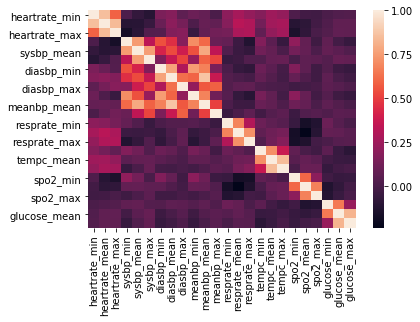

In [65]:
corr = df_adults[df_adults.columns[7:-1]].corr()
sns.heatmap(corr)

In [66]:
# stratified sampling of train and test sets using multi-class labels
X = df_adults.drop(['subject_id', 'hadm_id', 'icustay_id', 'discharge_location',
                    'diagnosis','hospital_expire_flag'], axis=1)
y = df_adults.hospital_expire_flag
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, test_size=0.2, \
                                                    shuffle=True, stratify=y, random_state=rnd_state)

In [67]:
print('Shape of training set: {}'.format(X_train_orig.shape))
print('Shape of test set: {}'.format(X_test_orig.shape))
print('Number of positives in training set: {}'.format(y_train.sum()))
print('Number of positives in test set: {}'.format(y_test.sum()))

Shape of training set: (42120, 26)
Shape of test set: (10531, 26)
Number of positives in training set: 5154
Number of positives in test set: 1289


In [68]:
num_features = ['heartrate_min', 'heartrate_mean', 'heartrate_max', 'sysbp_min', 'sysbp_mean', 'sysbp_max',
                'diasbp_min', 'diasbp_mean', 'diasbp_max', 'meanbp_min', 'meanbp_mean', 'meanbp_max',
                'resprate_min', 'resprate_mean', 'resprate_max', 'tempc_min', 'tempc_mean', 'tempc_max',
                'spo2_min', 'spo2_mean', 'spo2_max', 'glucose_min', 'glucose_mean', 'glucose_max']
num_impute = ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
scale = ('scale', MinMaxScaler())
num_transformer = Pipeline([num_impute, scale])

cat_features = ['admission_type','marital_status']
cat_impute = ('cat_impute', SimpleImputer(strategy='constant', fill_value='missing'))
onehot = ('onehot', OneHotEncoder(handle_unknown='error'))
cat_transformer = Pipeline(steps=[cat_impute, onehot])

preprocessor = ColumnTransformer(transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

X_train = preprocessor.fit_transform(X_train_orig)
X_test = preprocessor.transform(X_test_orig)

In [69]:
knc = KNeighborsClassifier(3)
lr = LogisticRegression(random_state=rnd_state,solver='lbfgs',max_iter=1000,class_weight='balanced',C=1.0,tol=0.0001)
svc = LinearSVC(random_state=rnd_state,C=0.025,class_weight='balanced',max_iter=10000)
rbf_svc = SVC(gamma=2, C=1)
rfc = RandomForestClassifier(random_state=rnd_state,n_estimators=100)
abc = AdaBoostClassifier(random_state=rnd_state)
gbc = GradientBoostingClassifier(random_state=rnd_state)

for clf, name in [(lr, 'Logistic'),
                  #(rbf_svc, 'RBF SVC'),
                  (gbc, 'Gradient Boosting Classifier')]:
    if name == 'Logistic' or name == 'K Neighbors':    
        clf.fit(X_train, y_train)
    else:
        clf.fit(X_train, y_train,sample_weight=compute_sample_weight(class_weight='balanced', y=y_train))
    predictions = clf.predict(X_test)
    F1 = f1_score(y_test, predictions)
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    res = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
    print(name)
    print(res)

Logistic
TEST SET f1: 0.37 auroc: 0.71 precision: 0.26 recall: 0.70
Gradient Boosting Classifier
TEST SET f1: 0.41 auroc: 0.72 precision: 0.29 recall: 0.68


Text(0, 0.5, 'Feature Importance Score')

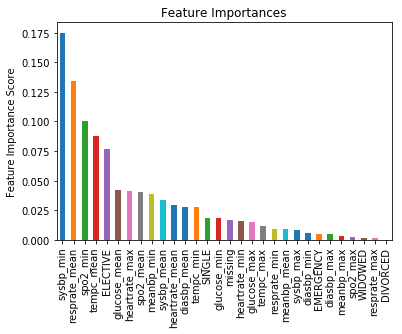

In [71]:
features = num_features + \
        preprocessor.transformers_[1][1].named_steps['onehot'].categories_[0].tolist() + \
        preprocessor.transformers_[1][1].named_steps['onehot'].categories_[1].tolist()
feat_imp = pd.Series(clf.feature_importances_, features).sort_values(ascending=False)
feat_imp.iloc[0:30].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')